In [55]:
%load_ext autoreload
%autoreload 2

from run_models import save_model, load_model
from plot_utils import *
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF

device = 'cmod'
dataset = 'random100'
numeric_feats = ['ip','Wmhd','n_e','kappa','li']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Load models and create disruption predictors

cph_model, cph_transformer = load_model('cph', device, dataset)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, numeric_feats, cph_transformer)

dcph_model, dcph_transformer = load_model('dcph', device, dataset)
dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, numeric_feats, dcph_transformer)

rsf_model, rsf_transformer = load_model('rsf', device, dataset)
rsf_predictor = DisruptionPredictorSM("Random Survival Forest", rsf_model, numeric_feats, rsf_transformer)

rf_model, rf_transformer = load_model('rf', device, dataset)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, numeric_feats, rf_transformer)


Loaded model from models/cph_cmod_random100.pkl
Loaded model from models/dcph_cmod_random100.pkl
Loaded model from models/rsf_cmod_random100.pkl
Loaded model from models/rf_cmod_random100.pkl


In [72]:
from evaluate_performance import benchmark

horizons = np.linspace(0, 0.8, 20)

au_rocs_cph = benchmark(cph_predictor, horizons, device, dataset+'_test')
au_rocs_dcph = benchmark(dcph_predictor, horizons, device, dataset+'_test')
au_rocs_rsf = benchmark(rsf_predictor, horizons, device, dataset+'_test')
au_rocs_rf = benchmark(rf_predictor, horizons, device, dataset+'_test')

print(au_rocs_cph)
print(au_rocs_dcph)
print(au_rocs_rsf)
print(au_rocs_rf)

[0.11374999999999999, 0.05499999999999999, 0.07500000000000001, 0.08375, 0.09625, 0.09625, 0.095, 0.09375, 0.07749999999999999, 0.06375, 0.08375, 0.09625, 0.09625, 0.09625, 0.05875000000000001, 0.07625000000000001, 0.07125000000000001, 0.08625000000000001, 0.08625000000000001, 0.0975]
[0.11374999999999999, 0.12250000000000001, 0.08875, 0.08500000000000002, 0.07750000000000001, 0.07125000000000002, 0.07625, 0.08375, 0.08125000000000002, 0.0675, 0.04875, 0.05625, 0.065, 0.04625, 0.05, 0.06000000000000001, 0.065, 0.0575, 0.07250000000000001, 0.07]
[0.12374999999999999, 0.12625, 0.0925, 0.0925, 0.06625000000000002, 0.04750000000000001, 0.046250000000000006, 0.058750000000000004, 0.065, 0.046250000000000006, 0.07125000000000001, 0.07125000000000001, 0.08250000000000002, 0.08250000000000002, 0.07875000000000001, 0.08000000000000002, 0.08500000000000002, 0.08000000000000002, 0.07875000000000001, 0.06625]
[0.1825, 0.09125, 0.05125000000000002, 0.05125000000000002, 0.06375000000000003, 0.033750

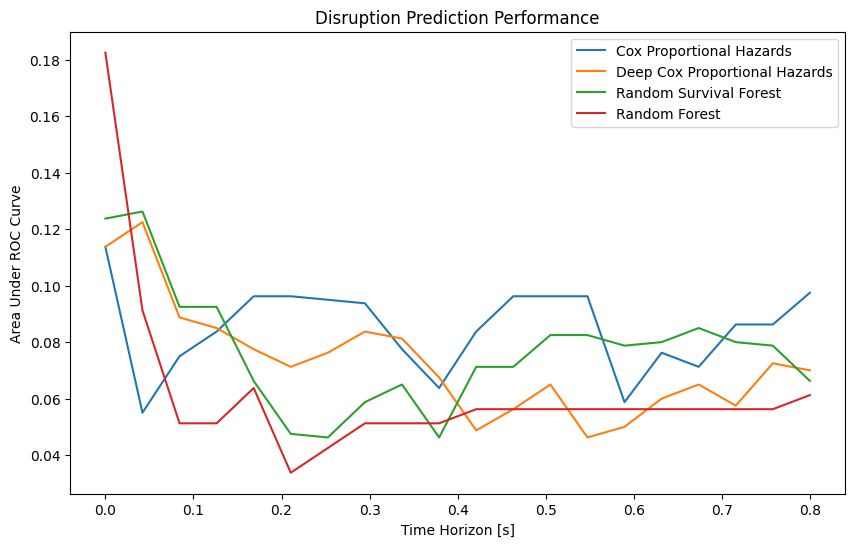

In [73]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(horizons, au_rocs_cph, label='Cox Proportional Hazards')
plt.plot(horizons, au_rocs_dcph, label='Deep Cox Proportional Hazards')
plt.plot(horizons, au_rocs_rsf, label='Random Survival Forest')
plt.plot(horizons, au_rocs_rf, label='Random Forest')
plt.xlabel('Time Horizon [s]')
plt.ylabel('Area Under ROC Curve')
plt.title('Disruption Prediction Performance')
plt.legend()
plt.show()



c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


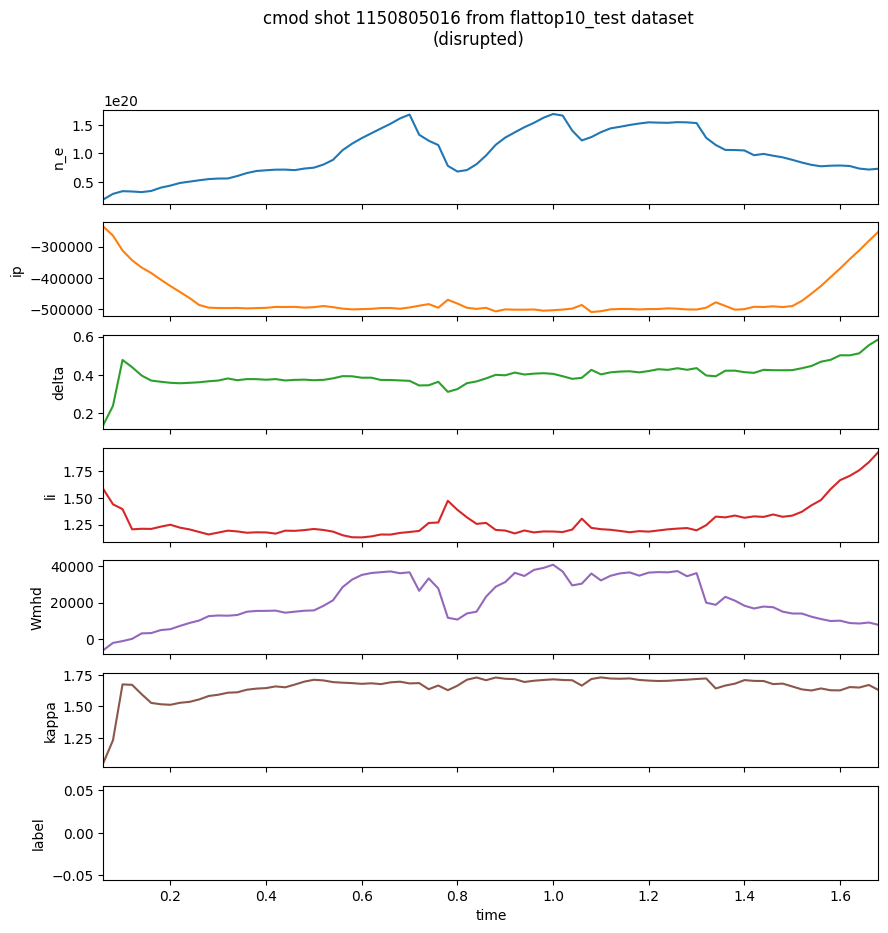

In [34]:
#plot_shot(device, dataset+'_test', 1150805022)
plot_shot(device, dataset+'_test', 1150805016)